In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from constants import EXTENSION_METHODS, RVSEC_ERRORS, REPETITIONS, TIMEOUTS, TOOLS, SUMMARY, METHOD_COVERAGE, \
    METHODS_JCA_COVERAGE, ACTIVITIES_COVERAGE

In [3]:
fdroid_spreadsheet = "fdroid/final_apps_to_download.csv"

# https://drive.google.com/file/d/1TPAAzWHarsoFP1poZcidBZKtlDoBOtkP/view?usp=drive_link
exp01_generic_instrument_errors_file = "exp01_generic_instrument_errors.json"
exp01_generic_results_file = "exp01_generic_results.json"

exp01_jca_instrument_errors_file = "exp01_jca_instrument_errors.json"
exp01_jca_results_file = "exp01_jca_results.json"


exp02_generic_instrument_errors_file = "exp02_generic_instrument_errors.json"
exp02_generic_results_file = "exp02_generic_results.json"

exp02_jca_instrument_errors_file = "exp02_jca_instrument_errors.json"
exp02_jca_results_file = "exp02_jca_results.json"

# TOTALS

In [4]:
def get_totals(results_file: str, instrument_errors_file: str, print_debug=False):
    if not results_file or not instrument_errors_file:
        return None
    
    total_instrumented = 0
    total_instrument_errors = 0

    apks_with_errors = set()

    with open(results_file, "r") as f:
        result = json.load(f)
        total_instrumented = len(result)
        for apk in result:
            for rep in result[apk][REPETITIONS]:
                for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                    for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                        tool_result = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool]
                        errors = tool_result[RVSEC_ERRORS]
                        if len(errors) > 0:
                            apks_with_errors.add(apk)
                            continue
                        
    intstrumentation_tool_error = {"dex2jar":0, "ajc": 0, "d8": 0}
    with open(instrument_errors_file, "r") as f:
        result = json.load(f)
        total_instrument_errors = len(result)
        for apk in result:
            tool = result[apk]["tool"]
            intstrumentation_tool_error[tool] += 1        

    total_experiment_apks = total_instrumented + total_instrument_errors
    instrumented_pct = (total_instrumented * 100) / total_experiment_apks
    apks_com_erros_pct = (len(apks_with_errors) * 100) / total_experiment_apks
    instrumented_apks_com_erros_pct = (len(apks_with_errors) * 100) / total_instrumented
    total_apks_with_errors = len(apks_with_errors)

    inst_tool_error_dex2jar_total = intstrumentation_tool_error["dex2jar"]
    inst_tool_error_dex2jar_pct = 0 if total_instrument_errors==0 else (inst_tool_error_dex2jar_total * 100) / total_instrument_errors
    inst_tool_error_ajc_total = intstrumentation_tool_error["ajc"]
    inst_tool_error_ajc_pct = 0 if total_instrument_errors==0 else (inst_tool_error_ajc_total * 100) / total_instrument_errors
    inst_tool_error_d8_total = intstrumentation_tool_error["d8"]
    inst_tool_error_d8_pct = 0 if total_instrument_errors==0 else (inst_tool_error_d8_total * 100) / total_instrument_errors

    if print_debug:
        print("FDROID: 4162")
        print("TOTAL: {} (apks que usam jca)".format(total_experiment_apks))
        print("INSTRUMENTADOS: {}".format(total_instrumented))
        print("INSTRUMENTADOS (%): {}".format(instrumented_pct))
        print("ERROS_INSTRUMENTACAO: {}".format(total_instrument_errors))
        print("  - dex2jar: {} ({} %)".format(inst_tool_error_dex2jar_total, inst_tool_error_dex2jar_pct))
        print("  - ajc: {} ({} %)".format(inst_tool_error_ajc_total, inst_tool_error_ajc_pct))
        print("  - d8: {} ({} %)".format(inst_tool_error_d8_total, inst_tool_error_d8_pct))
        print("APKS_COM_ERROS_ENCONTRADOS: {}".format(total_apks_with_errors))
        print("APKS_COM_ERROS_ENCONTRADOS (% do TOTAL): {}".format(apks_com_erros_pct))
        print("APKS_COM_ERROS_ENCONTRADOS (% do INSTRUMENTADOS): {}".format(instrumented_apks_com_erros_pct))
    
    return {
        "total": total_experiment_apks,
        "instrumented": total_instrumented,
        "instrumentation_errors": {
            "total": total_instrument_errors,
            "dex2jar": inst_tool_error_dex2jar_total,
            "ajc": inst_tool_error_ajc_total,
            "d8": inst_tool_error_d8_total
        },
        "apks_with_errors": total_apks_with_errors
    }

def get_totals_df():
    header = ["name", "total", "instrumented", "inst_err_total", "inst_err_dex2jar", "inst_err_ajc", "inst_err_d8", "apks_with_rv_errors"]
    data = []

    add_to_data("exp01_jca", get_totals(exp01_jca_results_file, exp01_jca_instrument_errors_file), data)
    add_to_data("exp01_generic", get_totals(exp01_generic_results_file, exp01_generic_instrument_errors_file), data)
    add_to_data("exp02_jca", get_totals(exp02_jca_results_file, exp02_jca_instrument_errors_file), data)
    add_to_data("exp02_generic", get_totals(exp02_generic_results_file, exp02_generic_instrument_errors_file), data)
   
    return pd.DataFrame(data, columns=header)

    
def add_to_data(name: str, total_dict: dict, data: list):
    if total_dict:
        data.append([name, total_dict["total"], total_dict["instrumented"], 
                     total_dict["instrumentation_errors"]["total"], 
                     total_dict["instrumentation_errors"]["dex2jar"],
                     total_dict["instrumentation_errors"]["ajc"],
                     total_dict["instrumentation_errors"]["d8"],
                     total_dict["apks_with_errors"]])

In [ ]:
# get_totals(exp01_jca_results_file, exp01_jca_instrument_errors_file, print_debug=True)
# get_totals(exp01_generic_results_file, exp01_generic_instrument_errors_file, print_debug=True)
# get_totals(exp02_jca_results_file, exp02_jca_instrument_errors_file, print_debug=True)

df = get_totals_df()
print(df)

# COVERAGE

In [5]:
import os


def get_coverage_df(results_file: str):
    if not os.path.exists(results_file):
        return None
    header = ["apk", "rep", "timeout", "tool", "cov_act", "cov_method", "cov_rv_method", "errors"]
    cov = []
    with open(results_file, "r") as f:
        result = json.load(f)
        for apk in result:
            for rep in result[apk][REPETITIONS]:
                for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                    for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                        summary = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool][SUMMARY]                        
                        errors = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool][RVSEC_ERRORS]
                        # print(f"{apk}:{rep}:{timeout}:{tool}:::{summary}")
                        # print(errors)
                        
                        cont_error = 0
                        if "total" in errors:
                            cont_error = errors["total"]
                        else:
                            cont_error = len(errors)
                            
                        cov.append([apk, int(rep), int(timeout), tool, 
                                    summary[ACTIVITIES_COVERAGE],
                                    summary[METHOD_COVERAGE],
                                    summary[METHODS_JCA_COVERAGE],
                                    cont_error])
                    
        return pd.DataFrame(cov, columns=header)
             
    
def get_coverage_avg_total_df():
    header = ["name", "cov_act", "cov_method", "cov_rv_method", "errors"]
    data = []

    add_to_cov_data("exp01_jca", get_coverage_df(exp01_jca_results_file), data)
    add_to_cov_data("exp01_generic", get_coverage_df(exp01_generic_results_file), data)
    add_to_cov_data("exp02_jca", get_coverage_df(exp02_jca_results_file), data)
    add_to_cov_data("exp02_generic", get_coverage_df(exp02_generic_results_file), data)
   
    return pd.DataFrame(data, columns=header)
    
def add_to_cov_data(name: str, df: pd.DataFrame, data: list):
    if df is None:
        return
    data.append([name, df["cov_act"].mean(), df["cov_method"].mean(), df["cov_rv_method"].mean(), df["errors"].mean()])

                                   

In [25]:
# df = get_coverage_df(exp02_jca_results_file)
# print(df.columns)
# print(df.dtypes)
# print(df)

avg_total = get_coverage_avg_total_df()
print(avg_total)

# print("\nEXP01_JCA:")
# print(get_coverage_df(exp01_jca_results_file).groupby('timeout')[['cov_act', 'cov_method', 'cov_rv_method']].mean())
# # print(get_coverage_df(exp01_jca_results_file).groupby('tool')[['cov_act', 'cov_method', 'cov_rv_method']].mean())

# print("\nEXP01_GENERIC:")
# print(get_coverage_df(exp01_generic_results_file).groupby('timeout')[['cov_act', 'cov_method', 'cov_rv_method']].mean())

# print("\nEXP02_JCA:")
# print(get_coverage_df(exp02_jca_results_file).groupby('timeout')[['cov_act', 'cov_method', 'cov_rv_method']].mean())
# # print(get_coverage_df(exp02_jca_results_file).groupby('tool')[['cov_act', 'cov_method', 'cov_rv_method']].mean())

# print("\nEXP02_GENERIC:")
# print(get_coverage_df(exp02_generic_results_file).groupby('timeout')[['cov_act', 'cov_method', 'cov_rv_method']].mean())

            name    cov_act  cov_method  cov_rv_method      errors
0      exp01_jca  35.758379   15.124904       8.557662    0.879141
1  exp01_generic  36.463813   13.644021      20.147549  203.477790
2      exp02_jca  61.543084   38.413854      22.380952    1.200000
3  exp02_generic  53.835601   32.987279      54.380370  997.042857


## experimentando os resultados .........................................

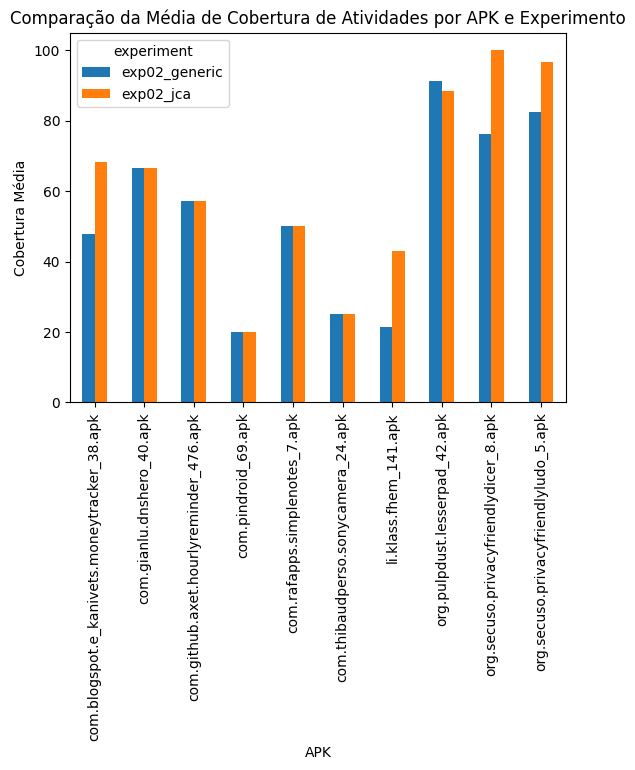

experiment                                   exp02_generic   exp02_jca
apk                                                                   
com.blogspot.e_kanivets.moneytracker_38.apk      47.959184   68.367347
com.gianlu.dnshero_40.apk                        66.666667   66.666667
com.github.axet.hourlyreminder_476.apk           57.142857   57.142857
com.pindroid_69.apk                              20.000000   20.000000
com.rafapps.simplenotes_7.apk                    50.000000   50.000000
com.thibaudperso.sonycamera_24.apk               25.000000   25.000000
li.klass.fhem_141.apk                            21.428571   42.857143
org.pulpdust.lesserpad_42.apk                    91.428571   88.571429
org.secuso.privacyfriendlydicer_8.apk            76.190476  100.000000
org.secuso.privacyfriendlyludo_5.apk             82.539683   96.825397


In [21]:
def get_coverage_df_with_experiment_name(experiment_name: str, results_file: str):
    if not os.path.exists(results_file):
        return None
    header = ["experiment", "apk", "rep", "timeout", "tool", "cov_act", "cov_method", "cov_rv_method", "errors"]
    cov = []
    with open(results_file, "r") as f:
        result = json.load(f)
        for apk in result:
            for rep in result[apk][REPETITIONS]:
                for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                    for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                        summary = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool][SUMMARY]                        
                        errors = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool][RVSEC_ERRORS]
                        
                        cont_error = 0
                        if "total" in errors:
                            cont_error = errors["total"]
                        else:
                            cont_error = len(errors)
                            
                        cov.append([experiment_name, apk, int(rep), int(timeout), tool, 
                                    summary[ACTIVITIES_COVERAGE],
                                    summary[METHOD_COVERAGE],
                                    summary[METHODS_JCA_COVERAGE],
                                    cont_error])
                    
        return pd.DataFrame(cov, columns=header)


exp02_jca_cov = get_coverage_df_with_experiment_name("exp02_jca", exp02_jca_results_file)
exp02_generic_cov = get_coverage_df_with_experiment_name("exp02_generic", exp02_generic_results_file)

df = pd.concat([exp02_jca_cov, exp02_generic_cov], ignore_index=True)


# exp02_cov_summary_by_apk = df.groupby('apk')['cov_act'].agg(['mean', 'min', 'max', 'median'])
# exp02_cov_summary_by_experiment_apk = df.groupby(['experiment', 'apk'])['cov_act'].agg(['mean', 'min', 'max', 'median'])
# exp02_cov_summary_by_experiment_apk_tool = df.groupby(['experiment', 'apk', "tool"])['cov_act'].agg(['mean'])
# print(exp02_cov_summary_by_experiment_apk_tool)



# resultados = df.groupby(['apk', 'experiment'])['cov_act'].mean().reset_index()
# import matplotlib.pyplot as plt
# # Criando um gráfico de barras
# resultados.pivot(index='apk', columns='experiment', values='cov_act').plot(kind='bar')
# plt.title('Comparação da Média de Cobertura de Atividades por APK e Experimento')
# plt.xlabel('APK')
# plt.ylabel('Cobertura Média')
# plt.show()
# # Criando uma tabela pivot
# tabela_pivot = resultados.pivot_table(index='apk', columns='experiment', values='cov_act')
# print(tabela_pivot)



# import pandas as pd
# # Agrupando por experimento, apk e tool, e calculando a média da cobertura
# resultados = df.groupby(['experiment', 'apk', 'tool'])['cov_act'].mean().reset_index()
# # Tabela pivot com médias e desvios padrão
# tabela_pivot = resultados.pivot_table(index=['experiment', 'apk'], columns='tool', values='cov_act', aggfunc=['mean', 'std'])
# print(tabela_pivot)
# #...
# import seaborn as sns
# sns.catplot(x='tool', y='cov_act', hue='experiment', data=resultados, kind='box')
# sns.lineplot(x='tool', y='cov_act', hue='experiment', data=resultados)
# plt.title('Comparação da Cobertura por Ferramenta e Experimento')
# plt.xticks(rotation=90)
# plt.show()




# exp02_cov_summary_by_tool = exp02_cov.groupby('tool')['cov_act'].agg(['mean', 'min', 'max', 'median'])
# print(exp02_cov_summary_by_tool)

# ERRORS

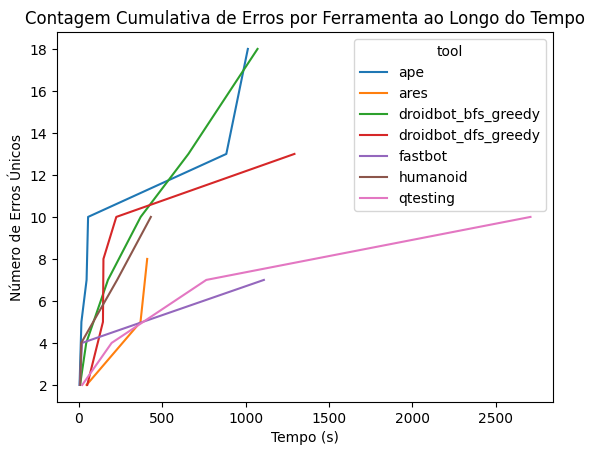

In [40]:
def get_errors_df_with_experiment_name(experiment_name: str, results_file: str):
    if not os.path.exists(results_file):
        return None
    header = ["experiment", "apk", "rep", "timeout", "tool", "error", "time"]
    data = []
    with open(results_file, "r") as f:
        result = json.load(f)
        for apk in result:
            for rep in result[apk][REPETITIONS]:
                for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                    for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:                                      
                        errors = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool][RVSEC_ERRORS]
                        for details in errors["details"]:            
                            unique_msg = "{}:::{}:::{}:::{}:::{}".format(details["class_full_name"], details["method"], details["spec"], details["error_type"], details["message"])
                            time_since_task_start = details["time_since_task_start"]
                            
                            data.append([experiment_name, apk, int(rep), int(timeout), tool, 
                                        unique_msg,
                                        time_since_task_start])
                    
        return pd.DataFrame(data, columns=header)
    
    

exp02_jca_err = get_errors_df_with_experiment_name("exp02_jca", exp02_jca_results_file)
# exp02_generic_err = get_errors_df_with_experiment_name("exp02_generic", exp02_generic_results_file)

# df = pd.concat([exp02_jca_err, exp02_generic_err], ignore_index=True)
df = exp02_jca_err



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupando e contando os erros por ferramenta e intervalo de tempo
df_grouped = df.groupby(['tool', 'time'])['error'].nunique().reset_index(name='error_count')

# Calculando a contagem cumulativa
df_grouped['cumulative_errors'] = df_grouped.groupby('tool')['error_count'].cumsum()

# Plotando o gráfico
sns.lineplot(x='time', y='cumulative_errors', hue='tool', data=df_grouped)
plt.title('Contagem Cumulativa de Erros por Ferramenta ao Longo do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Número de Erros Únicos')
plt.show()